# **BinaryClassification: Customer_Transaction_Predict**

1. **Define the Problem**
2. **Load and Check the Data**
    * 2.1 import data modeling libraries
    * 2.2 preview data, check for outliers and missing values
3. **Exploratory Data Analysis (EDA)**
    * 3.1 data visualization and statistics
    * 3.2 missing values imputation
    * 3.3 skewed data preprocessing
    * 3.4 reducing memory size
4. **Feature Engineering**
    * 4.1 Feature Interactions
    * 4.2 Feature Encodings
5. **Modeling & Hyperparameter Tunning**
    * 5.1 split dataset
    * 5.2 compare MLA models
    * 5.3 hyperparameter tunning
    * 5.4 plot learning curves
    * 5.5 feature importance and feature selection
    * 5.6 visualize the final tree structure
6. **Model Ensemble and Prediction**
    * 6.1 prediction correlations
    * 6.2 ensemble modeling
    * 6.3 predict and submit results

# **1. Define the Problem**
 
This kaggle project is to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The output Y is column "target" in the training dataset, which contains "1" for successful transaction and "0" for no transaction. This is a binary classification problem with supervised learning.

Submissions are evaluated on **area under the ROC curve** between the predicted probability and the observed target. So we need to use the **roc_auc_score** as our metrics.

# **2. Load and Check the Data**

**2.1 import data modeling libraries**


In [1]:
import pandas as pd
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, learning_curve, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegressionCV, PassiveAggressiveClassifier, RidgeClassifierCV, SGDClassifier, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

**2.2 preview data, check for outliers and missing values**

In [40]:
train = pd.read_csv("../input/santander-customer-transaction-prediction/train.csv")
test = pd.read_csv("../input/santander-customer-transaction-prediction/test.csv")

In [22]:
## preview the data and check missing values
train.info()
# test.info()
# train.isnull().sum()
print('\nTraing dataset:')
print('isnull: ' + str(Counter(train.isnull().sum())))
print('target_labels: ' + str(Counter(train['target'])) + '\n')
print('Testing dataset:')
print('isnull: ' + str(Counter(test.isnull().sum())) + '\n')

# train.sample(10)
train.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 203 entries, ID_code to ID
dtypes: float64(200), int64(1), object(2)
memory usage: 309.8+ MB

Traing dataset:
isnull: Counter({0: 203})
target_labels: Counter({0: 179902, 1: 20098})

Testing dataset:
isnull: Counter({0: 201})



,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,ID
count,200000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000
unique,200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200000
top,train_149224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180255
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,NaN,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,...,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537,NaN
std,NaN,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,...,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015,NaN
min,NaN,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,...,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800,NaN
25%,NaN,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,...,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475,NaN
50%,NaN,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,...,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550,NaN
75%,NaN,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,...,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800,NaN


In [4]:
## check the data outliers in each column
features = train.columns.values
outlier_indices = []

for col in features[2:]:
    # 1st quartile: 25%
    Q1 = np.percentile(train[col],25)
    # 3rd quartile: 75%
    Q3 = np.percentile(train[col],75)
    # interquartile range
    IQR = Q3 - Q1
    outlier_step = 1.5*IQR
    # generate a list of indices of outliers for feature col
    outlier_list_col = train[(train[col] < Q1-outlier_step) | (train[col] > Q3+outlier_step)].index 
    outlier_indices.extend(outlier_list_col)

# a dictionary that count outlier features for each row index 
outlier_indices = Counter(outlier_indices) 
print("Max number of features that has outlier values: ",max(outlier_indices.values()))


Max number of features that has outlier values:  4


> **As we see, the max number of outlier features a row could have is only 4, and it is out of 200 features. So we don't have to drop any outliers.**

# **3. Exploratory Data Analysis (EDA)**
**3.1 data visualization and statistics**

The column "ID_code" has 200K unique values and is not expected to be correlated to the prediction. Distribution plot of ID numbers with either target labels shows uniform distribution, and therefore we don't need to include the ID numbers in the modeling.

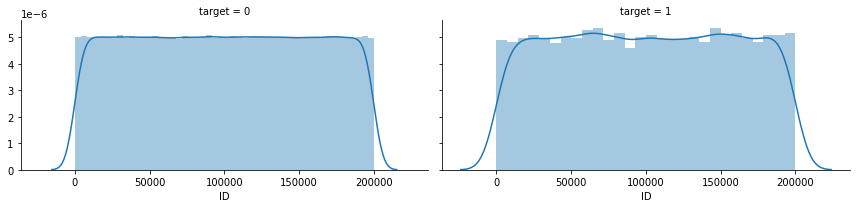

In [41]:
train_ID = [i.split("_")[1].strip() for i in train["ID_code"]]
train["ID"] = pd.Series(train_ID)
p = sns.FacetGrid(train,col='target',aspect=2)
p.map(sns.distplot,'ID')

For data visualization, we need to consider what kind of plots matches better with the data type.
In this dataset excluding the 'ID_code', we have two data types: (1) 'target': categorical; (2) 'var_#': numerical with continous values.

* **For categorical x-axis and numerical y-axis, we can use:** boxplot, barplot, violinplot, hist, etc.
* **For numerical x-axis and categorical legend, we can use:** displot, kdeplot, etc.

Here we cannot plot all 200 feature columns, so we will randomly pick a few for this checkout

0    179902
1     20098
Name: target, dtype: int64


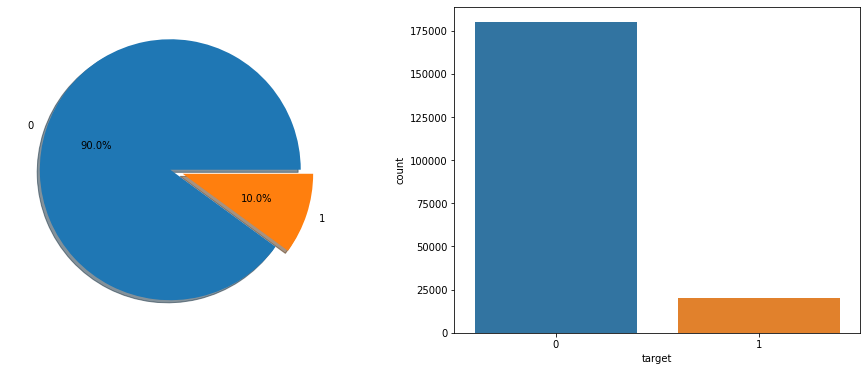

In [6]:
## firstly, visualize the label imbalance
print(train['target'].value_counts())

f,axe=plt.subplots(1,2,figsize=(16,6))
train['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=axe[0],shadow=True)
# axe[0].set_title('target')
axe[0].set_ylabel('')
sns.countplot('target',data=train,ax=axe[1])
# axe[1].set_title('target')
plt.show()

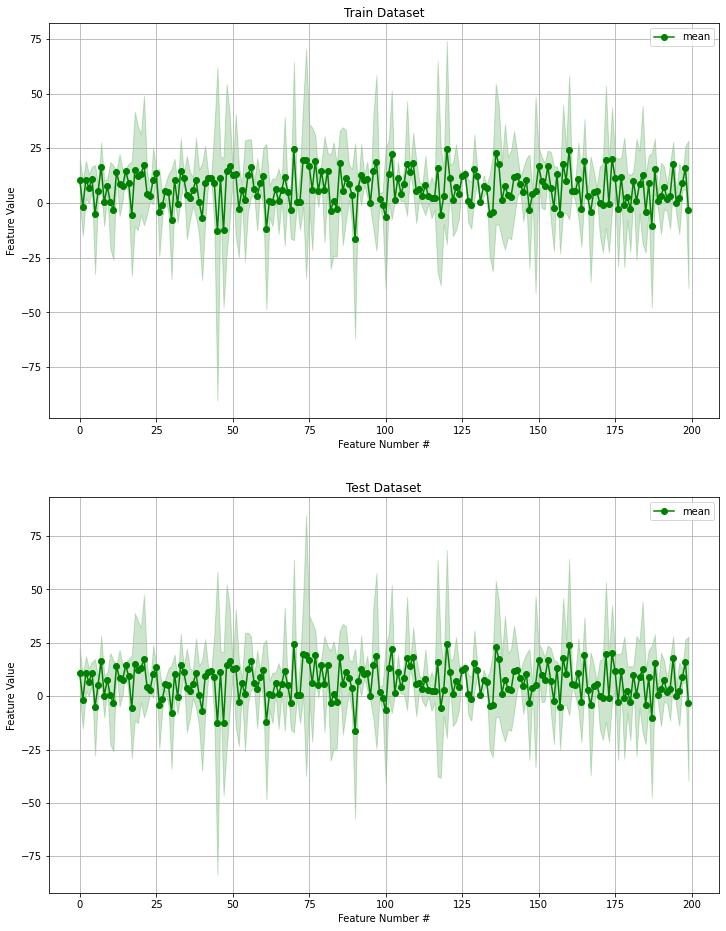

In [28]:
## plot all feature columns as well as their max/mean/min
describe_df_train = train.describe(include='all').drop(labels=['ID_code', 'target','ID'], axis=1)
# print(describe_df_train.columns.values)
feature_labels_train = np.array(describe_df_train.columns.str.lstrip('var_')).astype(np.int16)
feature_means_train = np.array(describe_df_train.loc['mean'])
feature_mins_train = np.array(describe_df_train.loc['min'])
feature_maxs_train = np.array(describe_df_train.loc['max'])

## plot all feature columns as well as their max/mean/min
describe_df_test = test.describe(include='all').drop(labels=['ID_code'], axis=1)
# print(describe_df_test.columns.values)
feature_labels_test = np.array(describe_df_test.columns.str.lstrip('var_')).astype(np.int16)
feature_means_test = np.array(describe_df_test.loc['mean'])
feature_mins_test = np.array(describe_df_test.loc['min'])
feature_maxs_test = np.array(describe_df_test.loc['max'])

## plot
plt.figure(figsize=(12,16))
plt.subplot(211)
plt.fill_between(feature_labels_train,feature_mins_train,feature_maxs_train,alpha=0.2,color='g')
plt.plot(feature_labels_train,feature_means_train,'o-',color='g',label='mean')
plt.title("Train Dataset");
plt.xlabel("Feature Number #")
plt.ylabel("Feature Value")
plt.legend(loc="best"); plt.grid()
plt.subplot(212)
plt.fill_between(feature_labels_test,feature_mins_test,feature_maxs_test,alpha=0.2,color='g')
plt.plot(feature_labels_test,feature_means_test,'o-',color='g',label='mean')
plt.title("Test Dataset");
plt.xlabel("Feature Number #")
plt.ylabel("Feature Value")
plt.legend(loc="best"); plt.grid()

In [8]:
## randomly choose a list of features to look at
feature_plot_list = []
for i in range(12):
    rand_feature = random.randrange(200)
    feature_plot_list.append('var_%d'%rand_feature)

## group by 'target' and show the mean
train[['target']+feature_plot_list].groupby('target').mean()

,var_4,var_193,var_2,var_1,var_0,var_170,var_89,var_5,var_52,var_152,var_147,var_115
target,,,,,,,,,,,,
0,11.072412,3.355403,10.665876,-1.695770,10.626681,-0.075908,3.678356,-5.146736,-2.575063,7.644020,-3.400584,2.257686
1,11.131337,3.120260,11.156633,-1.017613,11.156418,0.630093,4.144588,-4.336522,-2.114843,7.536336,-2.407399,1.820140


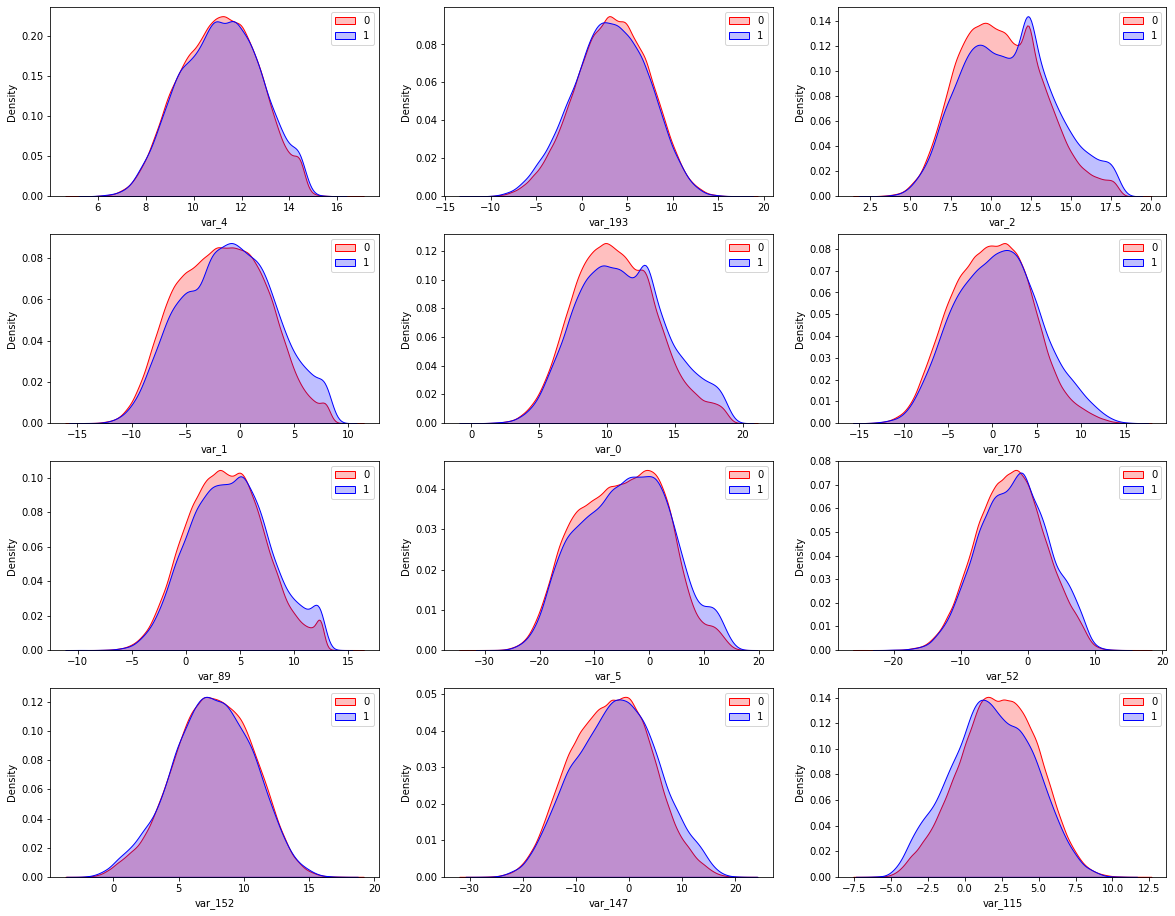

In [9]:
## plot the feature distributions by target
fig, axs = plt.subplots(4,3,figsize=(20,16))
feature_idx = 0
for i in range(4):
    for j in range(3): 
        g = sns.kdeplot(train[feature_plot_list[feature_idx]][train["target"] == 0], color="Red", ax =axs[i,j], shade = True)
        g = sns.kdeplot(train[feature_plot_list[feature_idx]][train["target"] == 1], color="blue", ax =axs[i,j], shade = True)
#         g = g.legend(["Skewness: %.2f"% (train[feature_plot_list[feature_idx]][train["target"] == 0].skew()),
#                       "Skewness: %.2f"% (train[feature_plot_list[feature_idx]][train["target"] == 1].skew())])
        g.legend(["0","1"])
        feature_idx += 1

**3.2 missing values imputation**

From the data preview in step 2.2, we saw no missing values in either the training dataset or the test dataset.
So here we can skip this step of filling the missing values.


**3.3 skewed data preprocessing**

In the data visualization in step 3.1, we looked at randomly picked features and the skewness are very small.
So we can skip this step as well.

**3.4 reducing memory size**

From the plotted feature values in step 3.1, we can see that all features have mean value in the range of (0,25) and max range within (-100,100). So we can consider to reduce the memory size of train/test dataframes in order to facilitate modeling step.

In [42]:
def reduce_memory_usage(df):
    col2int_list = []
    for col in df.columns:
        if col not in ['ID_code','target','ID']:
            isInt = False
            max_val = df[col].max()
            min_val = df[col].min()
            ## check if column can be convert into integer 
            col_series_asint = df[col].astype(np.int64)
            residule_series = df[col] - col_series_asint
            total_residule = residule_series.sum()
            if total_residule > -0.01 and total_residule < 0.01:
                isInt = True
                col2int_list.append(col)
            if isInt:
                df[col] = df[col].astype(np.int8)
            else:
                df[col] = df[col].astype(np.float16)
    return df, col2int_list
 

In [43]:
# start_mem_usg = train.memory_usage().sum() / 1024**2 
# print("Memory usage of train dataframe is :",start_mem_usg," MB") 
print ("############## train dataset #############")
print('Before reduce memory usuage:')
train.info()
print('\nAfter reduce memory usuage:')
train,_ = reduce_memory_usage(train)
train.info()
print ("\n############## test dataset #############")
print('Before reduce memory usuage:')
test.info()
print('\nAfter reduce memory usuage:')
test,_ = reduce_memory_usage(test)
test.info()

############## train dataset #############
Before reduce memory usuage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 203 entries, ID_code to ID
dtypes: float64(200), int64(1), object(2)
memory usage: 309.8+ MB

After reduce memory usuage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 203 entries, ID_code to ID
dtypes: float16(200), int64(1), object(2)
memory usage: 80.9+ MB

############## test dataset #############
Before reduce memory usuage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB

After reduce memory usuage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float16(200), object(1)
memory usage: 77.8+ MB


Here we can see that the memory usages of train and test datasets are significantly reduced.

# **4. Feature Engineering**

**4.1 Feature Interactions**


**4.2 Feature Encodings**



<AxesSubplot:>

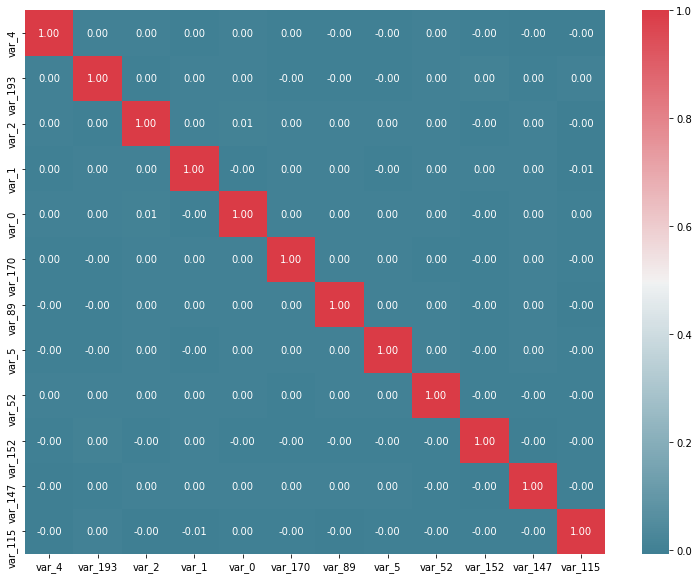

In [10]:
fig, axe = plt.subplots(figsize=(13,10))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(train[feature_plot_list].corr(),annot=True, fmt = ".2f", cmap = colormap, ax=axe)

# **5. Modeling & Hyperparameter Tunning**

**5.1 split dataset**

Here we will use 10-fold split of train and cross-validation dataset.

In [47]:
## define the X, Y of train/test set
Y_train = train['target']
X_train = train.drop(labels=['ID_code','target','ID'],axis=1)
X_test = test.drop(labels=['ID_code'],axis=1)
# split for cross-validation
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)

In [ ]:
rfc = RandomForestClassifier(random_state=0)
cv_results = cross_validate(rfc,X_train,Y_train,cv=kfold,return_train_score=True)

**5.2 compare MLA models**

Here we will compare a bunch of classifiers, looking at their cross-vaidating accuracy and training time.

In [ ]:
# MLA = [
#     #Ensemble Methods
#     AdaBoostClassifier(), BaggingClassifier(), ExtraTreesClassifier(),
#     GradientBoostingClassifier(), RandomForestClassifier(),
#     #Gaussian Processes
#     GaussianProcessClassifier(),
#     #GLM
#     LogisticRegressionCV(), PassiveAggressiveClassifier(),
#     RidgeClassifierCV(), SGDClassifier(),Perceptron(),
#     #Navies Bayes
#     BernoulliNB(), GaussianNB(),
#     #Nearest Neighbor
#     KNeighborsClassifier(),
#     #SVM
#     SVC(probability=True), NuSVC(probability=True), LinearSVC(),
#     #Trees    
#     DecisionTreeClassifier(), ExtraTreeClassifier(),
#     #Discriminant Analysis
#     LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(),
#     #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
#     XGBClassifier()    
#     ]

# print(MLA)

In [ ]:
# ## create a dataframe to report the training scores of each MLA
# MLA_columns = ['MLA_name','Parameters','Train_Accuracy','CV_Accuracy','CV_Accuracy_3Sigma','Training_Time']
# MLA_compare = pd.DataFrame(columns=MLA_columns)
# for alg in MLA:
#     print("Training:",str(alg.__class__.__name__))
#     cv_results = cross_validate(alg,X_train,Y_train,cv=kfold)
#     MLA_compare = MLA_compare.append({
#         'MLA_name': alg.__class__.__name__,
#         'Parameters': str(alg.get_params()),
#         'Train_Accuracy': cv_results['train_score'].mean(),
#         'CV_Accuracy': cv_results['test_score'].mean(),
#         'CV_Accuracy_3Sigma': cv_results['test_score'].std()*3,
#         'Training_Time': cv_results['fit_time'].mean() 
#     },ignore_index = True)

In [ ]:
# #view the comparison in table and plot (by CV accuracy)
# MLA_compare.sort_values(by=['CV_Accuracy'],ascending=False,inplace=True)
# sns.barplot(x='CV_Accuracy',y='MLA_name',data=MLA_compare,color='m')

In [ ]:
# #view the comparison in table and plot (by training time)
# MLA_compare.sort_values(by=['Training_Time'],ascending=False,inplace=True)
# sns.barplot(x='Training_Time',y='MLA_name',data=MLA_compare,color='m')